# Import packages and functions

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import time
import os
from PIL import Image
import atomai as aoi
import random
from scipy.ndimage import label

print(np.__version__)

1.26.3


In [ ]:
from autoscript_tem_microscope_client import TemMicroscopeClient
from autoscript_tem_microscope_client.enumerations import *
from autoscript_tem_microscope_client.structures import *

In [2]:
torch.manual_seed(0)

In [11]:
# model_l = torch.load('Model512_100.pt')
files = [file for file in os.listdir() if file.endswith('pt')]
print(files)
model_list = []
for file in files:
    model_list.append(torch.load(file))

['ModelNP_100.pt', 'ModelNP_1000.pt', 'ModelNP_200.pt', 'ModelNP_300.pt', 'ModelNP_400.pt', 'ModelNP_500.pt', 'ModelNP_600.pt', 'ModelNP_700.pt', 'ModelNP_800.pt', 'ModelNP_900.pt']


C:\Users\jcruanes\AppData\Local\Temp\ipykernel_5220\2119896107.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_list.append(torch.load(file))


### Movement

In [ ]:
# Spiral Grid Generatod, copied from the Hackathon project
def build_spiral_coordinates(total_cells = 12):
    coord_initial = []
    directions = [(0, 1), (-1, 0), (0, -1), (1, 0)]
    direction_index = 0
    step_count = 0
    step_limit = 1
    direction_changes = 0

    while len(coord_initial) < total_cells:

        coord_initial.append(directions[direction_index])
        step_count += 1

        if step_count == step_limit:
            step_count = 0
            direction_index = (direction_index + 1) % 4
            direction_changes += 1
            
            if direction_changes % 2 == 0:
                step_limit += 1

    return coord_initial

In [199]:
def load_image(directory, index):
    filename = f"image_{index:04d}.png" # This will add ceros if the index is 5 until there are 4 numbers
    path = os.path.join(directory, filename)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # This returns a image in grayscale
    # Maybe we should show a message if the image is not found, ask to Ivan
    return image

### Squares and particle detection

In [108]:
def isolate_particles(pred_mask, threshold=0.5):
    binary_mask = (pred_mask > threshold).astype(np.uint8)  # Convierte la máscara de probabilidades en una máscara binaria
    labeled_mask, num_particles = label(binary_mask) # Function from scipy.ndimage, busca grupos de píxeles conectados entre sí
    return labeled_mask, num_particles

In [ ]:
def get_square_bbox(indices, image_shape, ratio = 1, min_size = 0, max_size = 10000):
    rows, cols = indices
    if len(rows) == 0 or len(cols) == 0: 
        return None # Clean the list if there is no particle
    min_row, max_row = np.min(rows), np.max(rows) # Lookf or the limits
    min_col, max_col = np.min(cols), np.max(cols)
    width = max_col - min_col
    height = max_row - min_row
    side = int(max(width, height) * ratio)
    if side <= 0.2:
        return None

    # center of the particle
    row_center = (min_row + max_row) // 2
    col_center = (min_col + max_col) // 2
    half_side = side // 2

    # Calculate the top left square to put the square
    start_row = max(row_center - half_side, 0) 
    start_col = max(col_center - half_side, 0)

    # This assures that the box doesn't go out of the image, from Chat-GPT, check if there is a better option
    if start_row + side > image_shape[0]:
        start_row = image_shape[0] - side
    if start_col + side > image_shape[1]:
        start_col = image_shape[1] - side
        
    return (start_row, start_col, side)

In [ ]:
models = model_list[4], model_list[7], model_list[9], model_list[1] 
model = model_list[1]

# Main

In [ ]:
directory = 'images/'
os.makedirs(directory, exist_ok=True)

362
Batch 1/1
1 image was decoded in approximately 0.1104 seconds
Número de partículas detectadas: 0


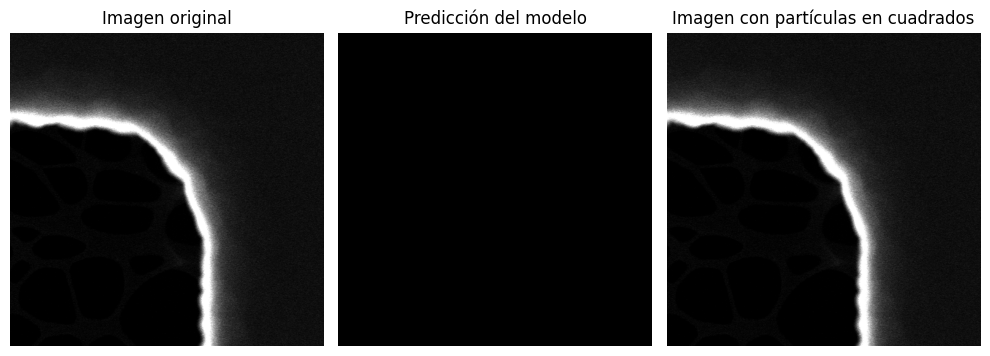

Batch 1/1
1 image was decoded in approximately 0.1007 seconds
Número de partículas detectadas: 0


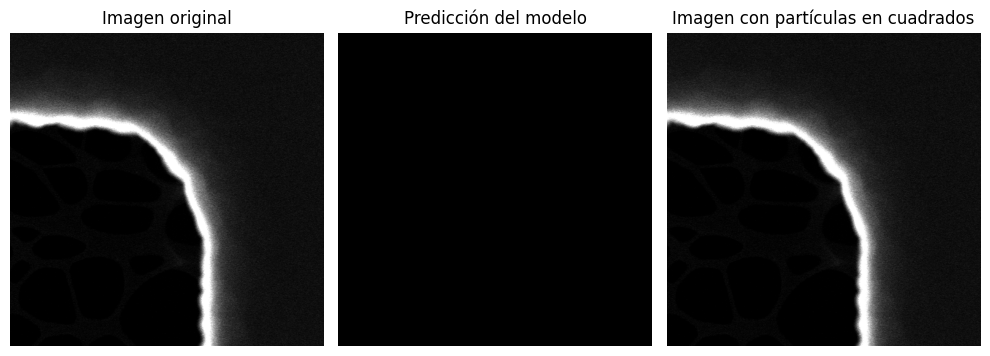

Batch 1/1
1 image was decoded in approximately 0.118 seconds
Número de partículas detectadas: 0


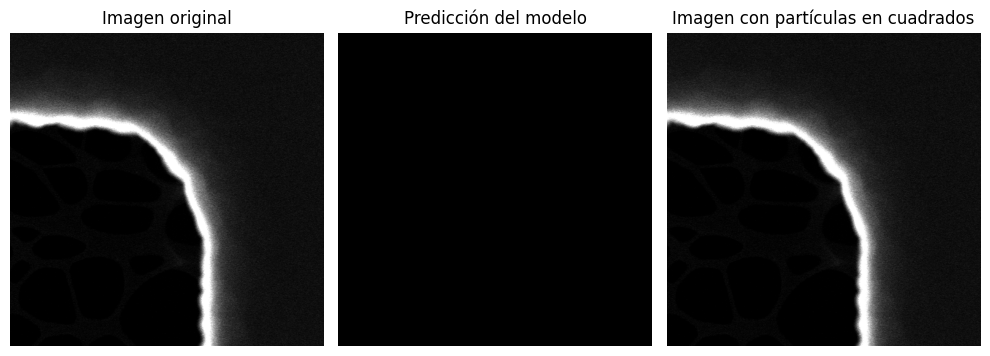

Batch 1/1
1 image was decoded in approximately 0.1049 seconds
(array([182], dtype=int64), array([225], dtype=int64))
(array([183, 183, 184, 184, 185, 185, 186, 186], dtype=int64), array([226, 227, 227, 228, 228, 229, 229, 230], dtype=int64))
(array([187], dtype=int64), array([231], dtype=int64))
(array([188], dtype=int64), array([232], dtype=int64))
(array([189], dtype=int64), array([233], dtype=int64))
(array([190], dtype=int64), array([234], dtype=int64))
(array([191], dtype=int64), array([235], dtype=int64))
(array([192], dtype=int64), array([236], dtype=int64))
(array([193, 194], dtype=int64), array([237, 237], dtype=int64))
(array([195, 196, 196, 197, 198, 198, 199, 199, 200], dtype=int64), array([238, 238, 239, 239, 239, 240, 240, 241, 241], dtype=int64))
(array([201], dtype=int64), array([242], dtype=int64))
(array([202], dtype=int64), array([243], dtype=int64))
(array([203], dtype=int64), array([244], dtype=int64))
(array([204, 205], dtype=int64), array([245, 245], dtype=int64)

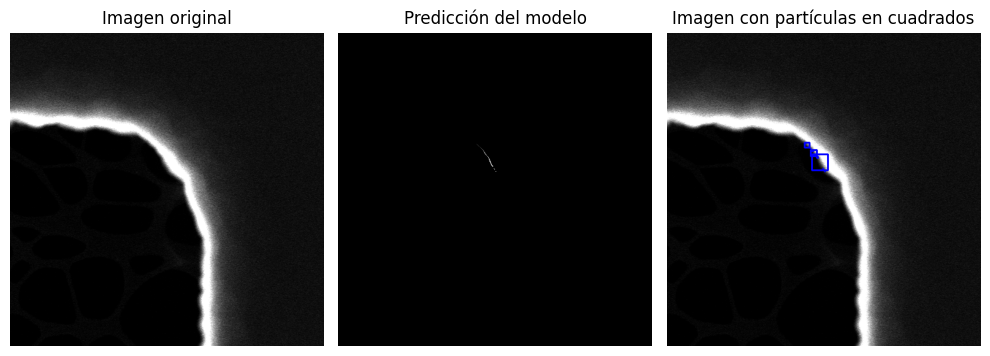

In [ ]:
def movement(grid_x, grid_y, step_size, microscope, index, th = 0.5):
    microscope.specimen.stage.relative_move(StagePosition(x=grid_x * step_size, y=grid_y * step_size)) # Move the microscope to the coordinates of the grid
    image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, ImageSize.PRESET_512, 1e-6) # Acquire the image

    pred, zones = model.predict(image) # Prediction and centered zones using our model
                
    pred_mask = np.squeeze(pred[0])
    labeled_mask, num_particles = isolate_particles(pred_mask, threshold=th)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    directory = f"Images/Image_{index}"
    os.makedirs(directory, exist_ok=True)

    previousX, previousY = None, None

    image.save(os.path.join(directory, f"image_{index}_0.png"))
    labeled_mask.save(os.path.join(directory, f"pred_{index}_0.png"))

    if(num_particles>0):    
        bboxes = []
        for x in range(1, num_particles + 1):
            particle_indices = np.where(labeled_mask == x)
            bbox = get_square_bbox(particle_indices, image.shape, 2)
            if bbox is not None:
                bboxes.append(bbox)
                start_row, start_col, side = bbox
                cv2.rectangle(image_color, (start_col, start_row), (start_col + side, start_row + side), (0, 0, 255), 2)

        image_color.save(os.path.join(directory, f"{index:04d}_detection.png"))       
        
        initial_position = microscope.specimen.stage.position

        for i, zone in enumerate(zones):
            if previousX is not None and previousY is not None:
                # Maybe we should use specimen.stage.move_to_pixel, ask to Ivan
                microscope.specimen.stage.relative_move(StagePosition(x=zone.x - previousX, y=zone.y - previousY))
            else:
                fov = microscope.optics.scan_field_of_view
                extra = fov / 2
                microscope.specimen.stage.relative_move(StagePosition(x=zone.x - extra, y=zone.y - extra))

            previousX, previousY = zone.x, zone.y
            centered_image = microscope.acquisition.acquire_stem_image(DetectorType.HAADF, ImageSize.PRESET_512, 1e-6)
            centered_image.save(os.path.join(directory, f"{i:04d}_image.png"))
    
    microscope.specimen.stage.absolute_move_safe(initial_position)
    # image = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # This returns a image in grayscale
    # Maybe we should show a message if the image is not found, ask to Ivan
    return


In [381]:
# Tamaños máximos y minimos a cuadrados, si mide menos de un nanometro no toma la imagen (aqui con pixeles)
# Tomar imagen de cada cuadrado
# Guardar
# Hacer la parte main de este codigo una funcion para poder llamarla desde el main
# Pasar a autoscript (magnificar)
# Por cada imagen, guardar una carpeta con imagen global, imagen de cuadraditos e imagen de nanoparticulas